In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def get_progress_csv(exp_dir, env_id):
    exp_dir = os.scandir(exp_dir)
    lst_ret_series, lst_cost_series = [], []
    for set_of_exps in exp_dir:
        if set_of_exps.is_dir() and env_id in set_of_exps.name:
            param_dir = os.scandir(set_of_exps)
            for set_of_params in param_dir:
                if set_of_params.is_dir():
                    exp_dir = os.scandir(set_of_params)
                    for single_exp in exp_dir:
                        if single_exp.is_dir():
                            seed_dir = os.scandir(single_exp)
                            for single_seed in seed_dir:
                                if single_seed.is_dir():
                                    progress_df = pd.read_csv(os.path.join(single_seed.path, 'progress.csv'))
                                    lst_ret_series.append(progress_df['Metrics/EpRet'])
                                    lst_cost_series.append(progress_df['Metrics/EpCost'])
                            seed_dir.close()
                    exp_dir.close()
            param_dir.close()
    exp_dir.close()
    all_ret_df = pd.concat(lst_ret_series, axis=1)
    ret_df = pd.DataFrame()
    ret_df['MeanReturn'] = all_ret_df.mean(axis=1)
    ret_df['StdReturn'] = all_ret_df.std(axis=1)

    all_cost_df = pd.concat(lst_cost_series, axis=1)
    cost_df = pd.DataFrame()
    cost_df['MeanCost'] = all_cost_df.mean(axis=1)
    cost_df['StdCost'] = all_cost_df.std(axis=1)
    
    return ret_df, cost_df

In [3]:
def plot_training(env_ids, ppol_dict, ppoc_dict, ppoh_dict, fig_name):
    plt.style.use('default')
    fig, axs = plt.subplots(2, len(env_ids), figsize=(len(env_ids) * 4, 2 * 3))
    
    for y, env_id in enumerate(env_ids):
        
        for x, metric in enumerate(['Return', 'Cost']):
    
            # print(env_id, metric)        
    
            ppol_mean_metric = ppol_dict[env_id][x]['Mean' + metric]
            ppol_std_metric = ppol_dict[env_id][x]['Std' + metric]
            axs[x, y].plot(ppol_dict[env_id][x].index * steps_per_epoch[env_id], 
                           ppol_mean_metric, 
                           'g-', label = 'PPO-Lagrangian (Oracle)')
            
            axs[x, y].fill_between(ppol_dict[env_id][x].index * steps_per_epoch[env_id], 
                                   ppol_mean_metric - ppol_std_metric, ppol_mean_metric + ppol_std_metric,
                                   color='green', alpha = 0.2)
    
            ppoc_mean_metric = ppoc_dict[env_id][x]['Mean' + metric]
            ppoc_std_metric = ppoc_dict[env_id][x]['Std' + metric]
            axs[x, y].plot(ppoc_dict[env_id][x].index * steps_per_epoch[env_id], 
                           ppoc_mean_metric, 
                           'r-', label = 'C-B Baseline (Zero Knowledge)')
            
            axs[x, y].fill_between(ppoc_dict[env_id][x].index * steps_per_epoch[env_id], 
                                   ppoc_mean_metric - ppoc_std_metric, ppoc_mean_metric + ppoc_std_metric,
                                   color='red', alpha = 0.2)
    
            ppoh_mean_metric = ppoh_dict[env_id][x]['Mean' + metric]
            ppoh_std_metric = ppoh_dict[env_id][x]['Std' + metric]
            axs[x, y].plot(ppoh_dict[env_id][x].index * steps_per_epoch[env_id], 
                           ppoh_mean_metric, 
                           'b-', label = 'TraCeS (Zero Knowledge)')
            
            axs[x, y].fill_between(ppoh_dict[env_id][x].index * steps_per_epoch[env_id], 
                                   ppoh_mean_metric - ppoh_std_metric, ppoh_mean_metric + ppoh_std_metric,
                                   color='blue', alpha = 0.2)
            
            if metric == 'Cost':
                axs[x, y].axhline(y=25, color='k', linestyle='--')
    
            if y == 0:
                axs[x, y].set_ylabel(metric, fontsize = 12)
            if x == 0:
                axs[x, y].set_title(env_id, fontsize = 13)
            elif x == 2 - 1:
                axs[x, y].set_xlabel('Steps', fontsize = 12)
            axs[x, y].grid(True)

    handles, labels = axs[0, -1].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(0., 0.88, 1., .102), loc='upper center', 
               ncol=3, borderaxespad=0.)
    fig.savefig(fig_name)
    

## Ant Domain

In [4]:
ppol_result_dir = '/SSD2/siowmeng/icml25_results/final_ppol/exp-x'
ppoc_result_dir = '/SSD2/siowmeng/icml25_results/final_ppoc/exp-x'
ppoh_result_dir = '/SSD2/siowmeng/icml25_results/final_ppoh/exp-x'
ppol_progress_dict, ppoc_progress_dict, ppoh_progress_dict = {}, {}, {}
env_ids = ['SafetyAntVelocity-v1', 'SafetyHalfCheetahVelocity-v1', 'SafetyHopperVelocity-v1', 'SafetyWalker2dVelocity-v1', 
           'SafetyPointCircle1-v0', 'SafetyPointCircle2-v0', 'SafetyCarCircle1-v0', 'SafetyCarCircle2-v0', 
           'SafetyAntRun-v0', 'SafetyBallRun-v0', 'SafetyCarRun-v0', 'SafetyDroneRun-v0',
          ]
steps_per_epoch = {
    'SafetyAntVelocity-v1': 20000, 
    'SafetyHalfCheetahVelocity-v1': 20000,
    'SafetyHopperVelocity-v1': 20000,
    'SafetyWalker2dVelocity-v1': 20000,
    'SafetyPointCircle1-v0': 20000,
    'SafetyPointCircle2-v0': 20000,
    'SafetyCarCircle1-v0': 20000,
    'SafetyCarCircle2-v0': 20000,
    'SafetyAntRun-v0': 2000,
    'SafetyBallRun-v0': 1000,
    'SafetyCarRun-v0': 2000,
    'SafetyDroneRun-v0': 2000,
}
for env_id in env_ids:
    ppol_progress_dict[env_id] = get_progress_csv(ppol_result_dir, env_id)
    ppoc_progress_dict[env_id] = get_progress_csv(ppoc_result_dir, env_id)
    ppoh_progress_dict[env_id] = get_progress_csv(ppoh_result_dir, env_id)

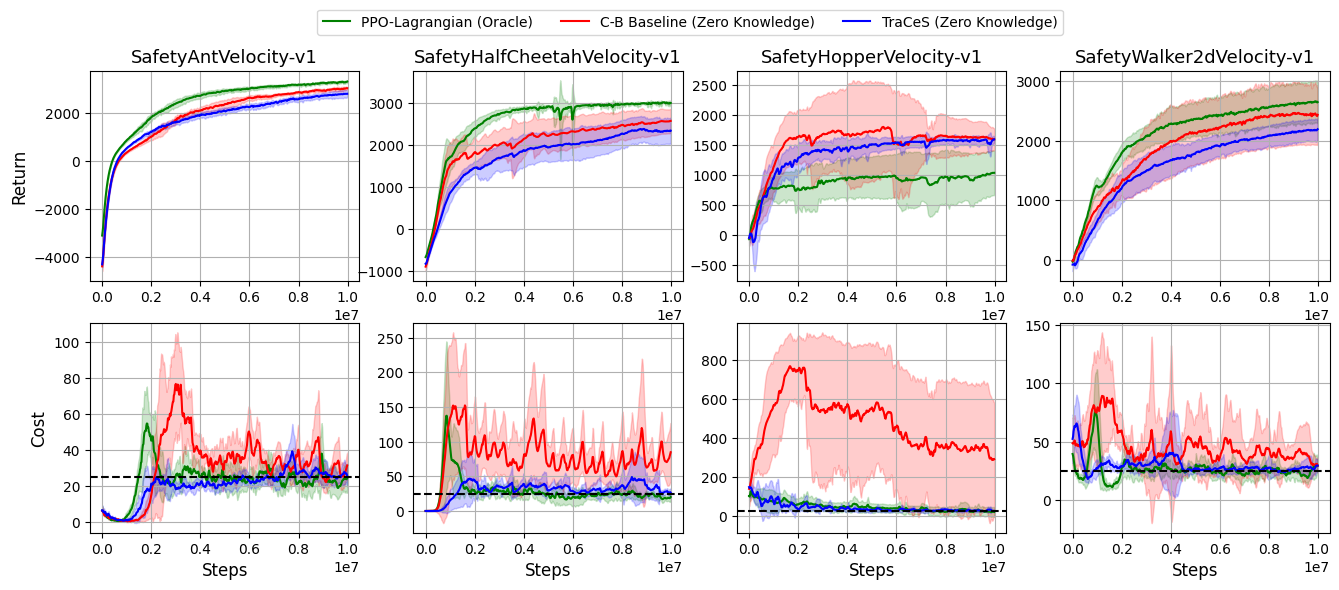

In [5]:
plot_training(['SafetyAntVelocity-v1', 'SafetyHalfCheetahVelocity-v1', 'SafetyHopperVelocity-v1', 'SafetyWalker2dVelocity-v1'], 
              ppol_progress_dict, ppoc_progress_dict, ppoh_progress_dict, 'MujocoVelocityTraining.pdf')

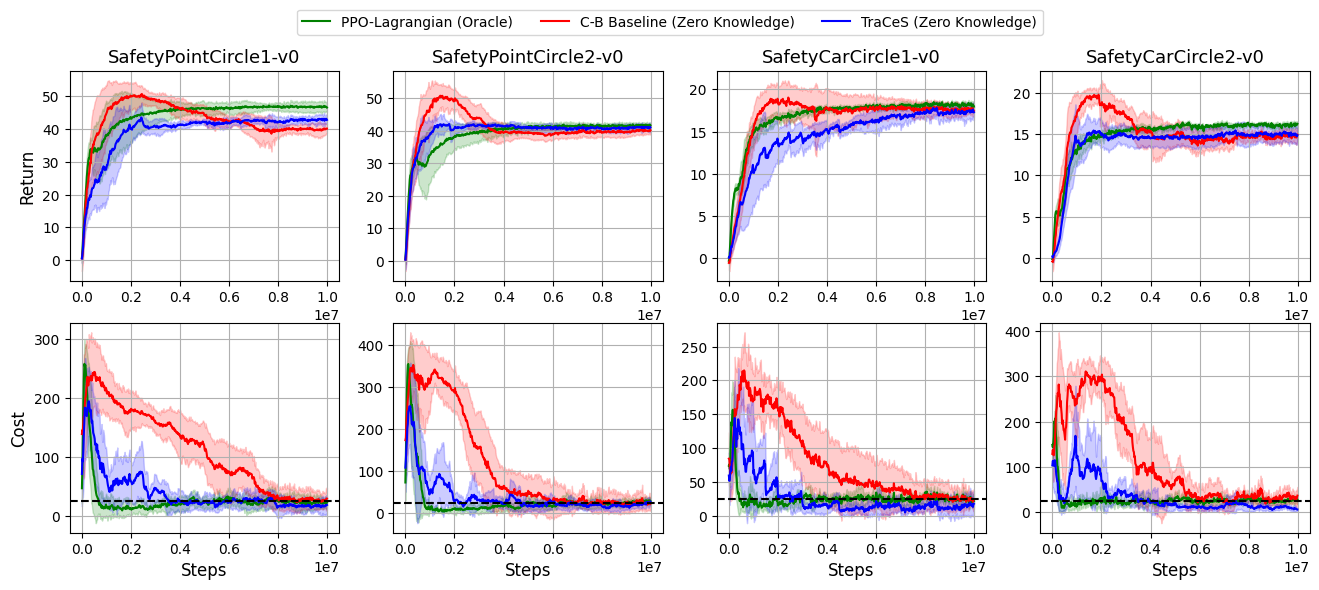

In [6]:
plot_training(['SafetyPointCircle1-v0', 'SafetyPointCircle2-v0', 'SafetyCarCircle1-v0', 'SafetyCarCircle2-v0'], 
              ppol_progress_dict, ppoc_progress_dict, ppoh_progress_dict, 'CircleTraining.pdf')

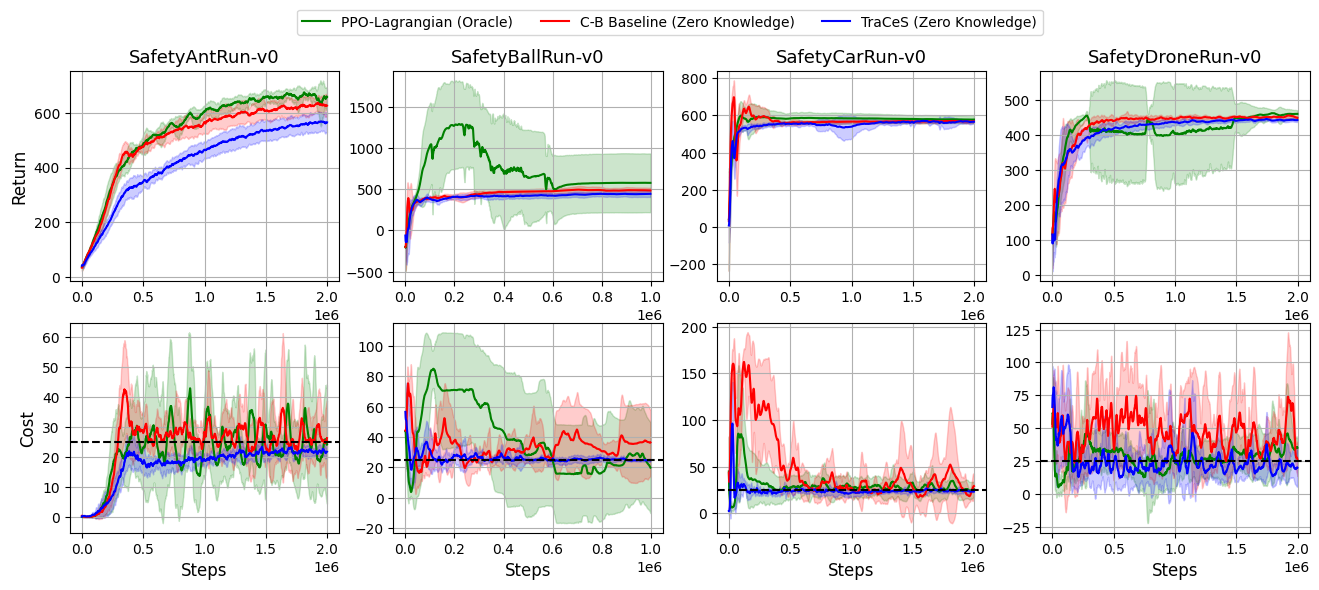

In [7]:
plot_training(['SafetyAntRun-v0', 'SafetyBallRun-v0', 'SafetyCarRun-v0', 'SafetyDroneRun-v0'], 
              ppol_progress_dict, ppoc_progress_dict, ppoh_progress_dict, 'BulletRunTraining.pdf')

## CV vs Random Abalation

In [8]:
def plot_abl_training(env_ids, random_dict, cv_dict, fig_name):
    plt.style.use('default')
    fig, axs = plt.subplots(2, len(env_ids), figsize=(len(env_ids) * 4, 2 * 3))
    
    for y, env_id in enumerate(env_ids):
        
        for x, metric in enumerate(['Return', 'Cost']):
    
            # print(env_id, metric)    
            random_mean_metric = random_dict[env_id][x]['Mean' + metric]
            random_std_metric = random_dict[env_id][x]['Std' + metric]
            axs[x, y].plot(random_dict[env_id][x].index * steps_per_epoch[env_id], 
                           random_mean_metric, 
                           'r-', label = 'TraCeS (Random Selection)')
            
            axs[x, y].fill_between(random_dict[env_id][x].index * steps_per_epoch[env_id], 
                                   random_mean_metric - random_std_metric, random_mean_metric + random_std_metric,
                                   color='red', alpha = 0.2)
    
            cv_mean_metric = cv_dict[env_id][x]['Mean' + metric]
            cv_std_metric = cv_dict[env_id][x]['Std' + metric]
            axs[x, y].plot(cv_dict[env_id][x].index * steps_per_epoch[env_id], 
                           cv_mean_metric, 
                           'b-', label = 'TraCeS (CV Selection)')
            
            axs[x, y].fill_between(cv_dict[env_id][x].index * steps_per_epoch[env_id], 
                                   cv_mean_metric - cv_std_metric, cv_mean_metric + cv_std_metric,
                                   color='blue', alpha = 0.2)
            
            if metric == 'Cost':
                axs[x, y].axhline(y=25, color='k', linestyle='--')
    
            if y == 0:
                axs[x, y].set_ylabel(metric, fontsize = 12)
            if x == 0:
                axs[x, y].set_title(env_id, fontsize = 13)
            elif x == 2 - 1:
                axs[x, y].set_xlabel('Steps', fontsize = 12)
            axs[x, y].grid(True)

    handles, labels = axs[0, -1].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(0., 0.88, 1., .102), loc='upper center', 
               ncol=3, borderaxespad=0.)
    fig.savefig(fig_name)

In [9]:
random_result_dir = '/SSD2/siowmeng/neurips25_results/ablation_results/random'
cv_result_dir = '/SSD2/siowmeng/neurips25_results/ablation_results/cv'
random_progress_dict, cv_progress_dict = {}, {}
env_ids = ['SafetyHopperVelocity-v1', 'SafetyBallRun-v0']

for env_id in env_ids:
    random_progress_dict[env_id] = get_progress_csv(random_result_dir, env_id)
    cv_progress_dict[env_id] = get_progress_csv(cv_result_dir, env_id)

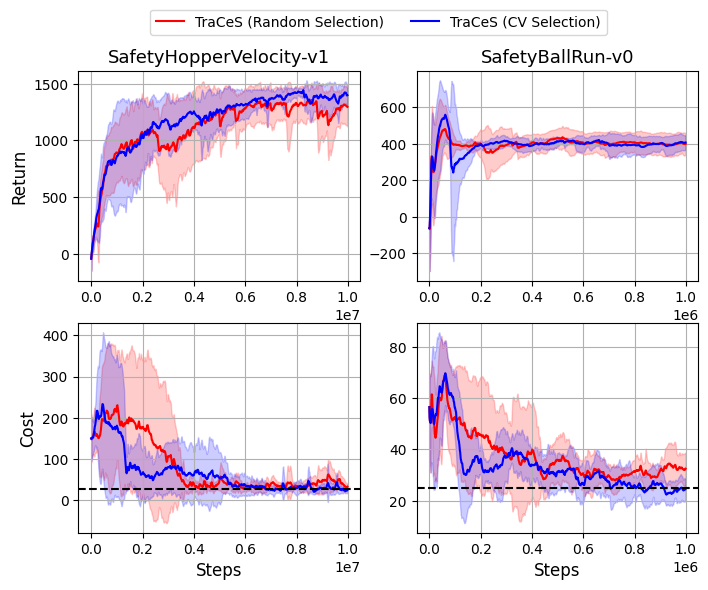

In [10]:
plot_abl_training(env_ids, random_progress_dict, cv_progress_dict, 'AblationTrainingCurves.pdf')